# Suggested software Anaconda :https://www.anaconda.com/products/distribution
# Before running , You will need to install geemap
`conda install -c conda-forge geemap`

## 1. File uploading 
## 2. Data extraction and downloading 
## 3. Visualization 
## 4. Image classification in cloud and locally with scikit-learn [popular machine learning library]

In [3]:
import ee, os, geemap,time,glob
import pandas as pd
import numpy as np
ee.Authenticate() # Authenticate to use the Google Earth Engine
ee.Initialize() # Initialize the library


Successfully saved authorization token.


# # Study area :
## Mississippi sound
##  Filelocation in cloud : 'projects/ee-hafezahmad10/assets/Mississippi_sound'
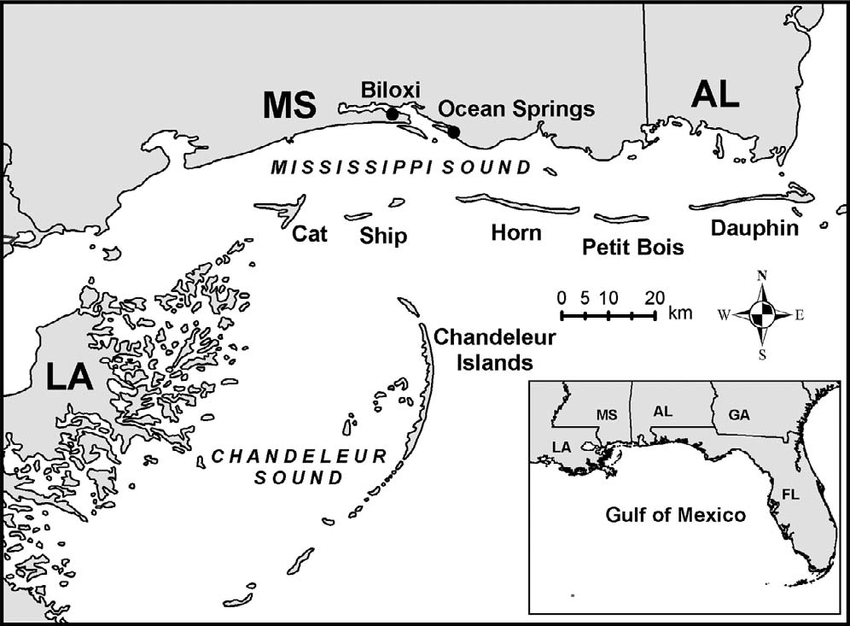

In [13]:
MsS=ee.FeatureCollection('projects/ee-hafezahmad10/assets/Mississippi_sound').geometry()
MsS

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Collection.geometry",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.loadTable",
          "arguments": {
            "tableId": {
              "constantValue": "projects/ee-hafezahmad10/assets/Mississippi_sound"
            }
          }
        }
      }
    }
  }
})

# See what I got?

In [14]:
Map = geemap.Map()
Map.addLayer(MsS, {})
Map.centerObject(MsS, 10)
Map

Map(center=[30.27792444884502, -88.88202972139742], controls=(WidgetControl(options=['position', 'transparent_…

##  Earth Engine Data Catalog --> https://developers.google.com/earth-engine/datasets  
<br>
Google Earth Engine contains more than 29 petabytes (1 petabyte = 1 million gigabytes) of cataloged raster and vector datasets

[Ocean related dataset ](https://developers.google.com/earth-engine/datasets/tags/ocean)

## For example 
### Dataset Availability : 2000-02-24T00:05:01Z–2022-02-28T21:00:01 , bands: chlor_a
###  ee.ImageCollection("NASA/OCEANDATA/MODIS-Terra/L3SMI")

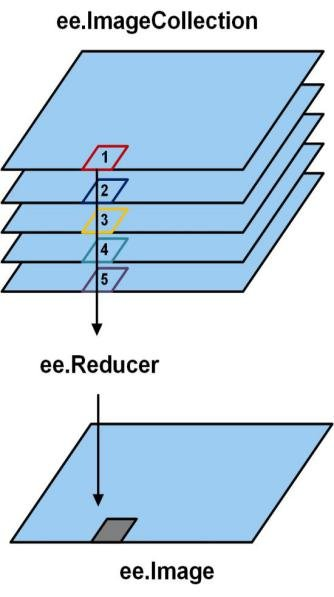

In [25]:
sst = ee.ImageCollection("NASA/OCEANDATA/MODIS-Terra/L3SMI").filterDate('2010-01-01','2021-03-06')
# define a function to get the mean value of the image
def poi_mean(img):
    # get the mean value of the image, and set it as a property of the image:4616 meters
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=MsS, scale=4616,maxPixels=1e9).get('sst')
    #  return the image with the new property with the mean value
    return img.set('date', img.date().format()).set('mean',mean)
#  apply the function to the image collection: use map() function for image collection
poi_reduced_imgs = sst.map(poi_mean)
#  now we can get the list of values
nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)
# now we can convert it to a pandas dataframe
df = pd.DataFrame(nested_list.getInfo(), columns=['date','n_sst'])
#unit : °C	-2*	45* Sea surface temperature
df.head(3)

,date,n_sst
0,2010-01-01T21:10:01,11.049965
1,2010-01-02T21:40:01,11.721609
2,2010-01-03T21:00:00,9.719624


<AxesSubplot:title={'center':'Sea Surface Temperature (°C)'}, xlabel='date'>

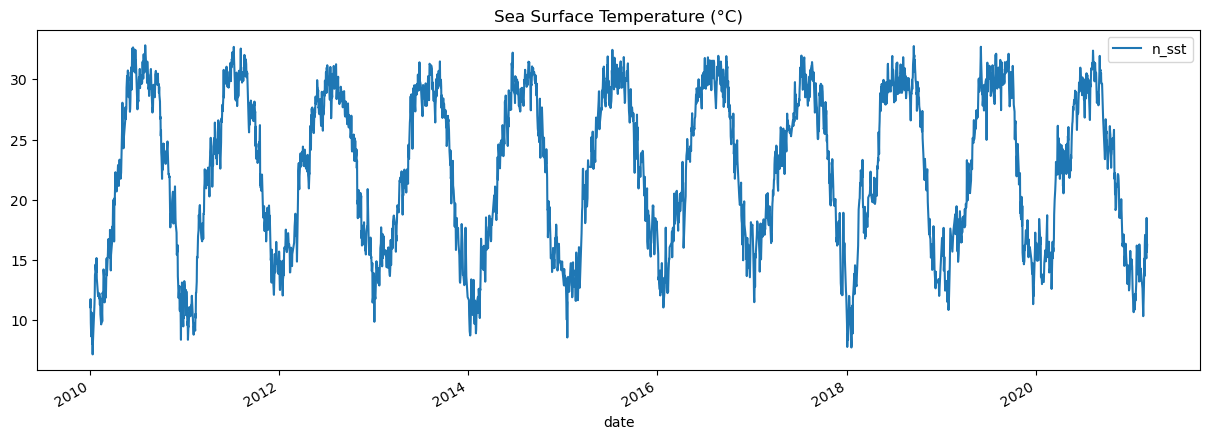

In [26]:
# make plot
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df.plot(figsize=(15,5),title='Sea Surface Temperature (°C)')
# Forecasting: ARIMA, SARIMA, SARIMAX, VAR, VARMA, VARMAX and LSTM, Prophet


In [29]:
df.reset_index(inplace=True)

# Linear regression model

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
# drop rows with missing values
df.dropna(inplace=True)
# check is there any missing values
print(df.isnull().sum())
df['date'] = pd.to_datetime(df['date'])
# create lag features for the time series data
for i in range(1, 13):
    df[f'lag_{i}'] = df['n_sst'].shift(i) # shift() function is used to shift index
# more details: https://www.w3resource.com/pandas/dataframe/dataframe-shift.php#:~:text=The%20shift()%20function%20is,with%20an%20optional%20time%20freq.&text=Number%20of%20periods%20to%20shift.
# split the data into training and testing sets
train = df[df['date'] < '2014-12-01']
test = df[df['date'] >= '2014-12-01']
train

date     0
n_sst    0
dtype: int64


,date,n_sst,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2010-01-01 21:10:01,11.049965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-02 21:40:01,11.721609,11.049965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-03 21:00:00,9.719624,11.721609,11.049965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-04 21:35:00,8.967833,9.719624,11.721609,11.049965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-05 22:00:00,8.606774,8.967833,9.719624,11.721609,11.049965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,2014-11-26 21:20:01,14.386411,15.661726,15.977833,14.229935,13.974083,15.349516,15.102830,15.122598,16.607912,19.397539,18.324520,19.864333,18.346776
1338,2014-11-27 21:50:01,15.043680,14.386411,15.661726,15.977833,14.229935,13.974083,15.349516,15.102830,15.122598,16.607912,19.397539,18.324520,19.864333
1339,2014-11-28 21:10:00,14.298567,15.043680,14.386411,15.661726,15.977833,14.229935,13.974083,15.349516,15.102830,15.122598,16.607912,19.397539,18.324520
1340,2014-11-29 21:40:00,15.380650,14.298567,15.043680,14.386411,15.661726,15.977833,14.229935,13.974083,15.349516,15.102830,15.122598,16.607912,19.397539


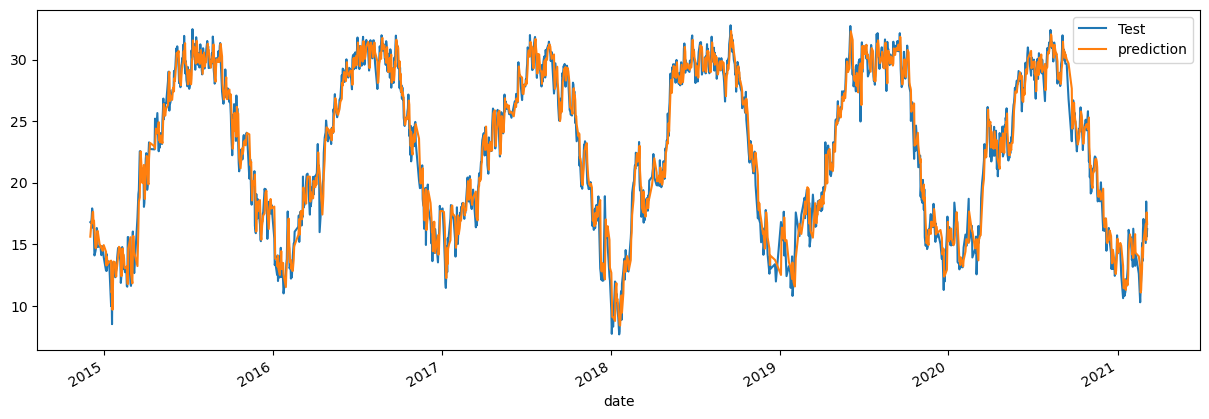

In [32]:
# drop null values from the training data
train.dropna(inplace=True)
# fit a linear regression model to the training data
X_train = train.drop(['date', 'n_sst'], axis=1)
y_train = train['n_sst']
model = LinearRegression() #
model.fit(X_train, y_train)

# make a forecast for the test data
X_test = test.drop(['date', 'n_sst'], axis=1)
y_test = test['n_sst']
y_pred = model.predict(X_test)

# plot the test data and the forecast
fig, ax = plt.subplots(figsize=(15,5))
test.set_index('date')['n_sst'].plot(ax=ax)
pd.Series(y_pred, index=test['date']).plot(ax=ax)
ax.legend(['Test', 'prediction'])
plt.show()


# # Data download

In [ ]:
start_date=['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01', '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01', '2000-09-01', '2000-10-01', '2000-11-01', '2000-12-01']
print(len(start_date))
end_date=['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31', '2000-09-30', '2000-10-31', '2000-11-30', '2000-12-31']
print(len(end_date))
print(start_date)
print(end_date)
# loop through the time intervals defined by the start and end dates
for i in range(len(start_date)):
    # filter the dataset by date and select the chlorophyll-a band
    dataset=ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI").filterDate(start_date[i], end_date[i]).select('chlor_a')
    # get the mean value of the image
    data = dataset.select('chlor_a').mean().clip(MsS)
    # now export the image to google drive
    task = ee.batch.Export.image.toDrive(image=data, description='chlorophyll-a', folder='chlorophyll-a', scale=4616, region=MsS, maxPixels=1e10)
    task.start()
print(task.status())
print("finished")

# Extract cloud cover percentage from National Land Cover Database (NLCD)

In [ ]:
# Define a list of years
years = [2001, 2004, 2006, 2008, 2011, 2013, 2016, 2019]

# Loop through each year in the list
for year in years:
    
    # Load the NLCD dataset for the current year
    dataset = ee.ImageCollection('USGS/NLCD_RELEASES/2019_REL/NLCD')
    dataset = dataset.filter(ee.Filter.eq('system:index', str(year))).first()
    
    # Select the landcover band from the dataset
    landcover = ee.Image(dataset.select('landcover'))
    
    # Load a geometry for the study area
    geometry = ee.FeatureCollection('projects/ee-hafezahmad10/assets/8basins')
    
    # Create an output directory if it doesn't already exist
    out_dir = os.path.join(os.getcwd(), 'data')
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    
    # Define the output file path for the current year
    nlcd_stats = os.path.join(out_dir, f'nlcd__single_{year}_pct.csv')
    
    # Compute zonal statistics (percentage of each landcover class) for the study area
    geemap.zonal_statistics_by_group(landcover, geometry, nlcd_stats, statistics_type='PERCENTAGE')

# Machine learning 

In [33]:
Map = geemap.Map()
# Memphis, TN:35.16311275416574, -90.06426016039394
point=ee.Geometry.Point([-90.06426016039394,35.16311275416574]) # longitude, latitude
# first classified image
esa = ee.Image( ee.ImageCollection("ESA/WorldCover/v100").first())
image = (
    # USGS Landsat 8 Level 2
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(point)
    .filterDate('2019-01-01', '2020-01-01')
    .sort('CLOUD_COVER')
    .first()
    .select('SR_B[1-7]')
)
# rescaling the image
image = image.multiply(0.0000275).add(-0.2).set(image.toDictionary())
vis_params = {'min': 0, 'max': 0.3, 'bands': ['SR_B5', 'SR_B4', 'SR_B3']}
# center the map
Map.centerObject(point, 8)
# add to the map
Map.addLayer(image, vis_params, "Landsat-8")
# show the map in the notebook
Map

Map(center=[35.16311275416574, -90.06426016039394], controls=(WidgetControl(options=['position', 'transparent_…

In [34]:
Map = geemap.Map()
landcover = esa.select('Map').clip(image.geometry())
Map.addLayer(landcover, {}, 'ESA Landcover')
Map.add_legend(title="Land cover type", builtin_legend='ESA_WorldCover')
# center the map
Map.centerObject(point, 8)
Map

Map(center=[35.16311275416574, -90.06426016039394], controls=(WidgetControl(options=['position', 'transparent_…

In [35]:
# get the training points
points = landcover.sample(
    **{
        'region': image.geometry(),
        'scale': 30,
        'numPixels': 5000,
        'seed': 0,
        'geometries': True,
    }
)

Map.addLayer(points, {}, 'training', False)

In [36]:
bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
label = 'Map'
features = image.select(bands).sampleRegions(
    **{'collection': points, 'properties': [label], 'scale': 30}
)

In [37]:
bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
label = 'Map'
features = image.select(bands).sampleRegions(
    **{'collection': points, 'properties': [label], 'scale': 30}
)
# band wise values
geemap.ee_to_df(features.limit(5))

,Map,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7
0,40,0.042687,0.053138,0.078603,0.102363,0.213985,0.287218,0.193607
1,40,0.051790,0.063202,0.094828,0.117240,0.198723,0.254630,0.189290
2,10,0.019753,0.020495,0.033475,0.028002,0.222757,0.146115,0.067327
3,60,0.072910,0.086880,0.124280,0.154942,0.267692,0.330145,0.252018
4,10,0.010265,0.012025,0.027865,0.018597,0.230403,0.104013,0.042907


In [38]:
params = {

    'features': features,
    'classProperty': label,
    'inputProperties': bands,

}
classifier = ee.Classifier.smileCart(maxNodes=None).train(**params)
classified = image.select(bands).classify(classifier).rename('landcover')

These classifiers include CART, RandomForest, NaiveBayes and SVM .. <br>
 [More ](https://developers.google.com/earth-engine/guides/classification)
Deep learning available -- [DEMO with Tensorflow multiclass prediction](https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/TF_demo1_keras.ipynb#scrollTo=bPU2VlPOikAy)

In [39]:
Map = geemap.Map()
Map.centerObject(point, 8)
Map.addLayer(classified.randomVisualizer(), {}, 'Classified')
Map

Map(center=[35.16311275416574, -90.06426016039394], controls=(WidgetControl(options=['position', 'transparent_…

In [40]:
class_values = {
    10: ['006400', 'Tree cover'],
    20: ['ffbb22', 'Shrubland'],
    30: ['ffff4c', 'Grassland'],
    40: ['f096ff', 'Cropland'],
    50: ['fa0000', 'Built-up'],
    60: ['b4b4b4', 'Bare/sparse vegetation'],
    70: ['f0f0f0', 'Snow and ice'],
    80: ['0064c8', 'Permanent water bodies'],
    90: ['0096a0', 'Herbaceous wetland'],
    95: ['00cf75', 'Mangroves'],
    100: ['fae6a0', 'Moss and lichen']
}
print(class_values.keys())
print(class_values.values())
# make it a list
colors=[class_values[value][0] for value in class_values]
legend_dict = {}
for value in class_values:
    color = class_values[value][0]
    description = class_values[value][1]
    legend_dict[description] = color
# set color for each class
classified_set=classified.remap(list(class_values.keys()), list(class_values.values()))
# make color pallete
hyperion_vis = {
    'min': 10,
    'max': 100,
    'palette': colors,
}
Map = geemap.Map()
Map.centerObject(point, 8)
Map.addLayer(classified,hyperion_vis , 'Land Cover Classification')
Map.add_legend(legend_title='Land Cover Classification', legend_dict=legend_dict)
Map

dict_keys([10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100])
dict_values([['006400', 'Tree cover'], ['ffbb22', 'Shrubland'], ['ffff4c', 'Grassland'], ['f096ff', 'Cropland'], ['fa0000', 'Built-up'], ['b4b4b4', 'Bare/sparse vegetation'], ['f0f0f0', 'Snow and ice'], ['0064c8', 'Permanent water bodies'], ['0096a0', 'Herbaceous wetland'], ['00cf75', 'Mangroves'], ['fae6a0', 'Moss and lichen']])


Map(center=[35.16311275416574, -90.06426016039394], controls=(WidgetControl(options=['position', 'transparent_…

LCD, ESA_WorldCover, ESRI_LandCover, ESRI_LandCover_TS, Dynamic_World, NWI, MODIS/051/MCD12Q1, MODIS/006/MCD12Q1, GLOBCOVER, JAXA/PALSAR, Oxford, AAFC/ACI, COPERNICUS/CORINE/V20/100m, COPERNICUS/Landcover/100m/Proba-V/Global, USDA/NASS/CDL, ALOS_landforms

In [ ]:
geemap.download_ee_image(
    classified,filename='ESA_ctg_supervised.tif',
    region=image.geometry(),
    scale=30)

In [ ]:
# download the image to google drive
ee.batch.Export.image.toDrive(
    image=classified,
    description='ESA_ctg_supervised',
    folder='gee',
    fileNamePrefix='ESA_ctg_supervised',
    region=image.geometry(),
    scale=30,
    maxPixels=1e13
).start()

# scikit-learn

In [72]:
# random forest
from sklearn.ensemble import RandomForestClassifier
from geemap import ml
image = (
    # USGS Landsat 8 Level 2
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(point)
    .filterDate('2019-01-01', '2020-01-01')
    .sort('CLOUD_COVER')
    .first()
    .select('SR_B[1-7]')
)
bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
label = 'Map'
features = image.select(bands).sampleRegions(
    **{'collection': points, 'properties': [label], 'scale': 30}
)
# band wise values
df=geemap.ee_to_df(features.limit(1000))

df.head()

,Map,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7
0,40,8825,9205,10131,10995,15054,17717,14313
1,40,9156,9571,10721,11536,14499,16532,14156
2,10,7991,8018,8490,8291,15373,12586,9721
3,60,9924,10432,11792,12907,17007,19278,16437
4,10,7646,7710,8286,7949,15651,11055,8833


In [61]:
X = df[bands ]
y = df[label]
n_trees = 10
rf = RandomForestClassifier(n_trees).fit(X, y)

In [73]:
#Convert a sklearn classifier object to a list of strings
trees = ml.rf_to_strings(rf, bands)
# Convert the list of strings to an ee.Classifier object
ee_classifier = ml.strings_to_classifier(trees)
# get the classification result
ee_classifier.getInfo()
# classify the image
classified = image.select(bands).classify(ee_classifier)

# Visualization

In [74]:
# center the map
Map = geemap.Map(center=(35.16311275416574,-90.06426016039394), zoom=10)
# raw image
image = (
    # USGS Landsat 8 Level 2
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(point)
    .filterDate('2019-01-01', '2020-01-01')
    .sort('CLOUD_COVER')
    .first()
    .select('SR_B[1-7]')
)
# rescaling the image
image = image.multiply(0.0000275).add(-0.2).set(image.toDictionary())
# add to the map
Map.addLayer(image, {'min': 0, 'max': 0.3, 'bands': ['SR_B5', 'SR_B4', 'SR_B3']}, "Landsat-8")
# make color pallete
hyperion_vis = {
    'min': 10,
    'max': 100,
    'palette': colors,
}
Map.addLayer(classified,hyperion_vis , 'Land Cover Classification')
Map

Map(center=[35.16311275416574, -90.06426016039394], controls=(WidgetControl(options=['position', 'transparent_…